# TRAINING THE AGE, ETHINICITY, GENDER MODEL

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from keras.regularizers import l2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    MaxPooling2D,
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from datetime import datetime

## Initializing the dataset

In [2]:
df = pd.read_csv('./dataset/age_gender.csv')
df.shape

(23705, 5)

## Pre-Process the dataset

#### Describe the dataset

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


### Visualize value count

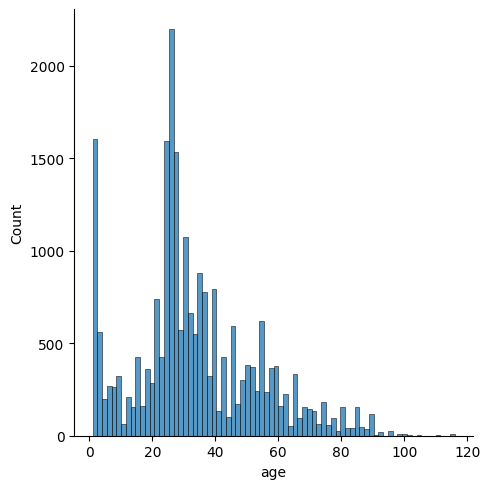

In [5]:
sns.displot(df['age'], kind='hist')

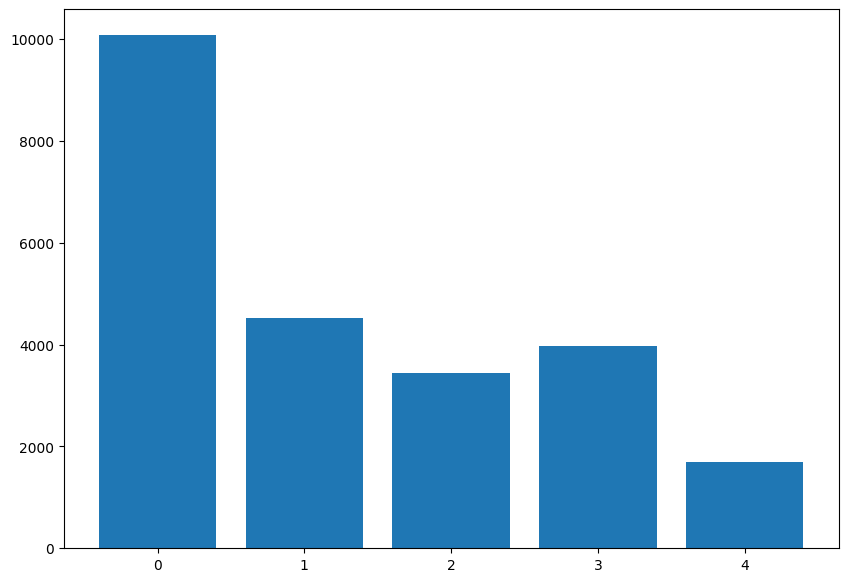

In [6]:
plt.figure(figsize=(10,7))
counts = df['ethnicity'].value_counts()
plt.bar(counts.index, counts.values)
plt.show()

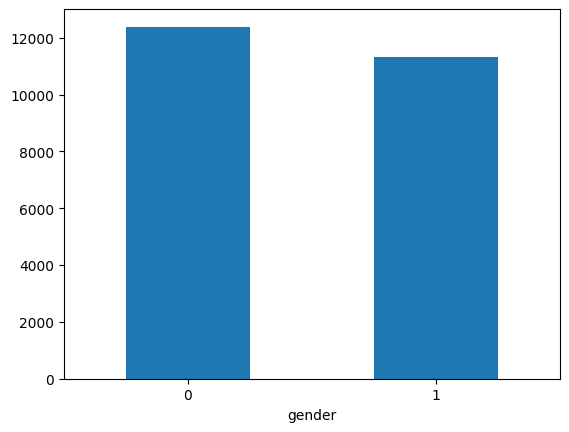

In [7]:
df["gender"].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.show()

### Normalize the dataset

In [8]:
df['pixels'] = df['pixels'].apply(
    lambda x:  np.array(
        x.split(),
        dtype="float32"
    )
)

In [9]:
X = np.array(df['pixels'].tolist()) / 255.0
X.shape

(23705, 2304)

### Convert the linear dataset to 48x48 array of pixels

In [10]:
X = X.reshape(-1, 48, 48, 1)
X.shape

(23705, 48, 48, 1)

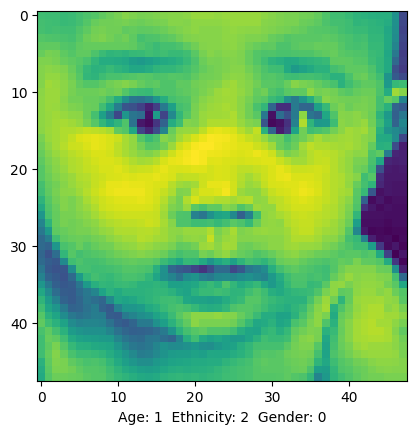

In [11]:
plt.imshow(X[0])
plt.xlabel(
    "Age: " +
    str(df['age'].iloc[0]) +
    "  Ethnicity: " +
    str(df['ethnicity'].iloc[0]) +
    "  Gender: " +
    str(df['gender'].iloc[0])
)
plt.show()

### Convert continuous to categorical

In [12]:
df["age"] = pd.cut(
    df["age"],
    bins=[0, 5, 18, 30, 45, 60, 80, 116],
    labels=["0", "1", "2", "3", "4", "5", "6"]
)

In [13]:
y = to_categorical(
    np.array(df['age']),
    num_classes=7
)

### Training constants

In [14]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_SHAPE = (48, 48, 1)

MODEL_AGE_LAYER_COUNT = 0
MODEL_ETHNICITY_LAYER_COUNT = 0
MODEL_GENDER_LAYER_COUNT = 0

## Age Model

### Split the training and test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state = 42
)

### Sequential CNN Model

In [16]:
model_age = Sequential()
model_age.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same', input_shape=INPUT_SHAPE))
model_age.add(BatchNormalization())
model_age.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'elu', kernel_initializer='he_normal', padding='same'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.3))

model_age.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_age.add(BatchNormalization())
model_age.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.4))

model_age.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_age.add(BatchNormalization())
model_age.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2, 2))
model_age.add(Dropout(0.5))

model_age.add(Flatten())

model_age.add(Dense(units=1024, activation='relu', kernel_initializer='he_uniform'))
model_age.add(BatchNormalization())
model_age.add(Dropout(0.5))

model_age.add(Dense(units=512, activation='relu', kernel_initializer='he_uniform'))
model_age.add(BatchNormalization())
model_age.add(Dropout(0.3))

model_age.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
model_age.add(BatchNormalization())

model_age.add(Dense(units=7, activation='softmax'))


# Compile model and check for formatting errors, define the
# loss function, the optimizer, learning rate, and the
# metrics (accuracy).
model_age.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(
        lr=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999
    ), 
    metrics=['accuracy']
)
model_age.summary()

MODEL_AGE_LAYER_COUNT = len(model_age.layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

c:\Users\Prerak\Desktop\Padhai\UNIV_STUFF\AML\AML_project_CLA4\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    patience=3,
    verbose=1,
    factor=0.5, 
    lr=LEARNING_RATE
)

### Training the model

In [18]:
history_age = model_age.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/200
296/296 [==============================] - 17s 40ms/step - loss: 1.4983 - accuracy: 0.4387 - val_loss: 1.3289 - val_accuracy: 0.4670 - lr: 0.0010
Epoch 2/200
296/296 [==============================] - 12s 39ms/step - loss: 1.1127 - accuracy: 0.5414 - val_loss: 1.2648 - val_accuracy: 0.4645 - lr: 0.0010
Epoch 3/200
296/296 [==============================] - 11s 39ms/step - loss: 1.0162 - accuracy: 0.5705 - val_loss: 1.0306 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 4/200
296/296 [==============================] - 11s 39ms/step - loss: 0.9491 - accuracy: 0.6005 - val_loss: 1.2914 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 5/200
296/296 [==============================] - 12s 39ms/step - loss: 0.9182 - accuracy: 0.6071 - val_loss: 1.0143 - val_accuracy: 0.5838 - lr: 0.0010
Epoch 6/200
296/296 [==============================] - 11s 39ms/step - loss: 0.8793 - accuracy: 0.6223 - val_loss: 0.8764 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 7/200
296/296 [==============================]

### Evaluate the model

In [19]:
loss, acc = model_age.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.8167858719825745
Test Accuracy: 0.6589326858520508


### Metrics plot

In [20]:
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={
        'index': 'epoch',
        'value': 'loss'
    },
    title='Training History'
)
fig.show()

### Save the weights

In [21]:
model_age.save(
    "./weights/age_{layers}-ep_{epochs}-lr_{learning_rate}-{timestamp}.h5"
    .format(
        layers=MODEL_AGE_LAYER_COUNT,
        epochs=EPOCHS,
        learning_rate=str(LEARNING_RATE).replace('.', '_'),
        timestamp=datetime.now().strftime("%d%m%Y_%H%M%S"),
    )
)

## Gender Model

### Split the training and test sets

In [22]:
y = df['gender'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

### Sequential CNN Model

In [23]:
model_gender = Sequential()
model_gender.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE, kernel_regularizer=l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))
model_gender.add(Dropout(0.2))

model_gender.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))
model_gender.add(Dropout(0.2))

model_gender.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))
model_gender.add(Dropout(0.2))
model_gender.add(Flatten())

model_gender.add(Dense(256, activation='relu'))
model_gender.add(Dense(1, activation='sigmoid'))

model_gender.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_gender.summary()

MODEL_GENDER_LAYER_COUNT = len(model_gender.layers)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 24, 24, 64)      

In [24]:
early_stopping = EarlyStopping(
    patience=10, 
    min_delta=0.001,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    lr=LEARNING_RATE
)

### Training the model

In [25]:
X_train.shape, y_train.shape

((18964, 48, 48, 1), (18964,))

In [26]:
history_gender = model_gender.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_data=(X_test, y_test), 
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/200
296/296 [==============================] - 4s 10ms/step - loss: 1.1714 - accuracy: 0.7648 - val_loss: 1.1434 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 2/200
296/296 [==============================] - 3s 10ms/step - loss: 0.5345 - accuracy: 0.8547 - val_loss: 0.5297 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 3/200
296/296 [==============================] - 3s 10ms/step - loss: 0.4271 - accuracy: 0.8701 - val_loss: 0.4240 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 4/200
296/296 [==============================] - 3s 9ms/step - loss: 0.3879 - accuracy: 0.8764 - val_loss: 0.3932 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 5/200
296/296 [==============================] - 3s 9ms/step - loss: 0.3761 - accuracy: 0.8815 - val_loss: 0.3882 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 6/200
296/296 [==============================] - 3s 9ms/step - loss: 0.3679 - accuracy: 0.8855 - val_loss: 0.4162 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 7/200
296/296 [==============================] - 3s 9ms

### Evaluate the model

In [27]:
loss, acc = model_gender.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.36459702253341675
Test Accuracy: 0.8842016458511353


### Metrics plot

In [28]:
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={
        'index': 'epoch', 
        'value': 'loss'
    }, 
    title='Training History'
)
fig.show()

### Save model weights

In [29]:
model_gender.save(
    "./weights/gender_{layers}-ep_{epochs}-lr_{learning_rate}-{timestamp}.h5"
    .format(
        layers=MODEL_GENDER_LAYER_COUNT,
        epochs=EPOCHS,
        learning_rate=str(LEARNING_RATE).replace('.', '_'),
        timestamp=datetime.now().strftime("%d%m%Y_%H%M%S"),
    )
)

## Ethnicity Model

In [30]:
ethnicity_matrix = np.array(df["ethnicity"])
y = to_categorical(ethnicity_matrix, num_classes=5)

### Split the training and test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state = 42
)

### Sequential CNN Model

In [32]:
model_ethnicity = Sequential()
model_ethnicity.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same', input_shape=INPUT_SHAPE))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'elu', kernel_initializer='he_normal', padding='same'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2,2))
model_ethnicity.add(Dropout(0.3))

model_ethnicity.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2,2))
model_ethnicity.add(Dropout(0.4))

model_ethnicity.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2, 2))
model_ethnicity.add(Dropout(0.5))

model_ethnicity.add(Flatten())

model_ethnicity.add(Dense(units=1024, activation='relu', kernel_initializer='he_uniform'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Dropout(0.5))

model_ethnicity.add(Dense(units=512, activation='relu', kernel_initializer='he_uniform'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Dropout(0.3))

model_ethnicity.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
model_ethnicity.add(BatchNormalization())

model_ethnicity.add(Dense(units=5, activation='softmax'))

model_ethnicity.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(
        lr=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999
    ), 
    metrics=['accuracy']
)
model_ethnicity.summary()

MODEL_ETHNICITY_LAYER_COUNT = len(model_ethnicity.layers)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

c:\Users\Prerak\Desktop\Padhai\UNIV_STUFF\AML\AML_project_CLA4\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



                                                                 
Total params: 11,250,629
Trainable params: 11,245,253
Non-trainable params: 5,376
_________________________________________________________________


In [33]:
early_stopping = EarlyStopping(
    patience=10, 
    min_delta=0.001,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=LEARNING_RATE
)

### Training the model

In [34]:
history_ethnicity = model_ethnicity.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_data=(X_test, y_test), 
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/200
296/296 [==============================] - 13s 40ms/step - loss: 1.2506 - accuracy: 0.5382 - val_loss: 1.3323 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 2/200
296/296 [==============================] - 12s 39ms/step - loss: 0.8673 - accuracy: 0.6906 - val_loss: 0.8044 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 3/200
296/296 [==============================] - 11s 39ms/step - loss: 0.7659 - accuracy: 0.7289 - val_loss: 0.7493 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 4/200
296/296 [==============================] - 12s 39ms/step - loss: 0.7048 - accuracy: 0.7509 - val_loss: 0.6430 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 5/200
296/296 [==============================] - 12s 39ms/step - loss: 0.6666 - accuracy: 0.7646 - val_loss: 0.6543 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 6/200
296/296 [==============================] - 12s 39ms/step - loss: 0.6249 - accuracy: 0.7815 - val_loss: 0.6309 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 7/200
296/296 [==============================]

### Evaluate the model

In [35]:
loss, acc = model_ethnicity.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.56186842918396
Test Accuracy: 0.8135414719581604


### Metrics plot

In [36]:
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={
        'index': 'epoch', 
        'value': 'loss'
    }, 
    title='Training History'
)
fig.show()

### Save model weights

In [37]:
model_ethnicity.save(
    "./weights/ethnicity_{layers}-ep_{epochs}-lr_{learning_rate}-{timestamp}.h5"
    .format(
        layers=MODEL_ETHNICITY_LAYER_COUNT,
        epochs=EPOCHS,
        learning_rate=str(LEARNING_RATE).replace('.', '_'),
        timestamp=datetime.now().strftime("%d%m%Y_%H%M%S"),
    )
)